In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline


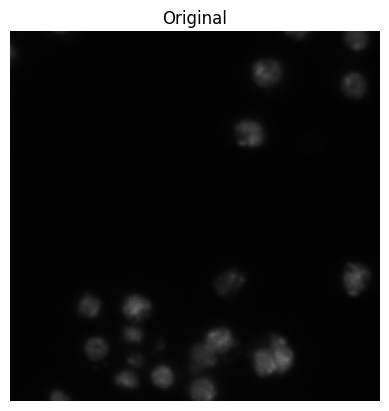

In [7]:
base_path = "data-science-bowl-2018/stage1_train"

sample_ids = os.listdir(base_path)
sample_id = sample_ids[0]

image_path = os.path.join(base_path, sample_id, "images")
mask_path = os.path.join(base_path, sample_id, "masks")

img_name = os.listdir(image_path)[0]

image = cv2.imread(os.path.join(image_path, img_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title("Original")
plt.axis("off")
plt.show()


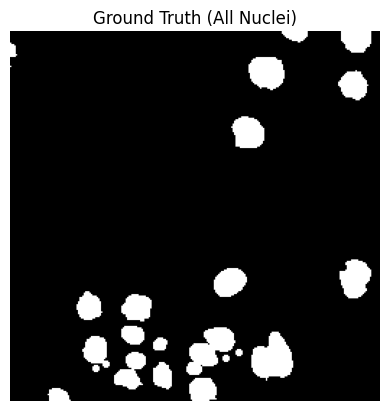

True nuclei: 27


In [8]:
mask_files = os.listdir(mask_path)

combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)

for m in mask_files:
    mask = cv2.imread(os.path.join(mask_path, m), 0)
    combined_mask = cv2.bitwise_or(combined_mask, mask)

plt.imshow(combined_mask, cmap='gray')
plt.title("Ground Truth (All Nuclei)")
plt.axis("off")
plt.show()

print("True nuclei:", len(mask_files))


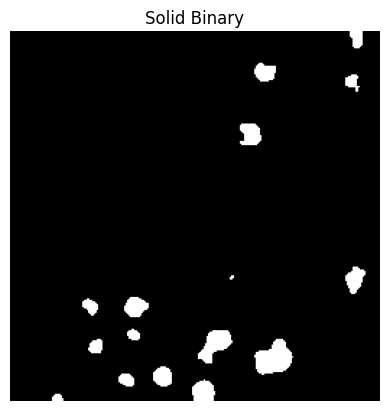

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray = cv2.GaussianBlur(gray, (5,5), 0)

_, binary = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)

kernel = np.ones((3,3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.imshow(binary, cmap='gray')
plt.title("Solid Binary")
plt.axis("off")
plt.show()


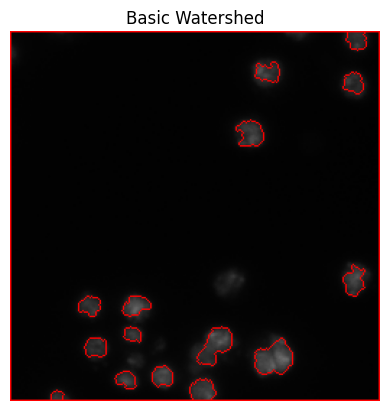

In [10]:
dist = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

_, sure_fg = cv2.threshold(dist, 0.3 * dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

sure_bg = cv2.dilate(binary, kernel, iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers_basic = cv2.watershed(image.copy(), markers)

image_basic = image.copy()
image_basic[markers_basic == -1] = [255, 0, 0]

plt.imshow(image_basic)
plt.title("Basic Watershed")
plt.axis("off")
plt.show()



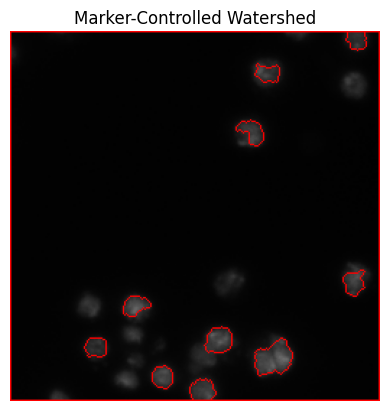

In [11]:
_, sure_fg = cv2.threshold(dist, 0.55 * dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

sure_bg = cv2.dilate(binary, kernel, iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers_controlled = cv2.watershed(image.copy(), markers)

image_controlled = image.copy()
image_controlled[markers_controlled == -1] = [255, 0, 0]

plt.imshow(image_controlled)
plt.title("Marker-Controlled Watershed")
plt.axis("off")
plt.show()



In [ ]:
num_basic = len(np.unique(markers_basic)) - 2
num_controlled = len(np.unique(markers_controlled)) - 2

print("Basic segments:", num_basic)
print("Marker-Controlled segments:", num_controlled)


Basic segments: 15
Marker-Controlled segments: 10


In [ ]:
#The segmentation underperforms because the fixed threshold and morphological closing merge multiple touching nuclei into single connected regions. As a result, the distance transform generates insufficient foreground markers. Since watershed relies entirely on these markers, it cannot correctly split all nuclei, leading to significant under-segmentation compared to the ground truth count of 27.